1.1.1
Read the image edgetest_23.png

c:\Users\odydr\anaconda3\envs\cv_lab1_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


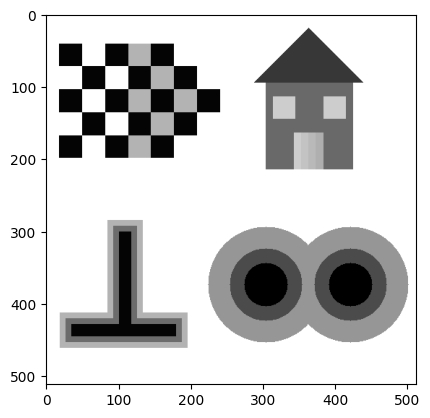

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img= cv2.imread('edgetest_23.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float)/255
plt.imshow(img, cmap='gray' )


1.1.2
Add noise to the picture.

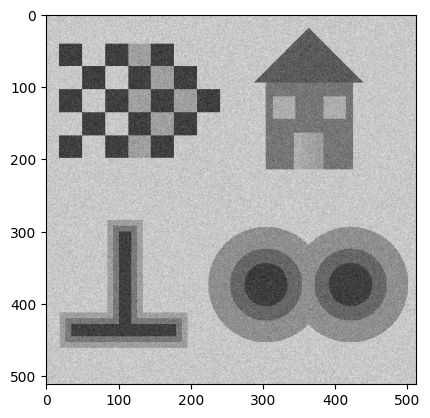

In [3]:
# i)


psnr = 20  
sigma = 0.1
mean=0

# Add the noise to the original image
noisy_img20 = np.random.normal(mean,sigma,img.shape)
noisy_img20 = noisy_img20.reshape(img.shape)
noisy_img20 = np.add(img, noisy_img20)

# Display the noisy image
plt.imshow(noisy_img20,cmap='gray')


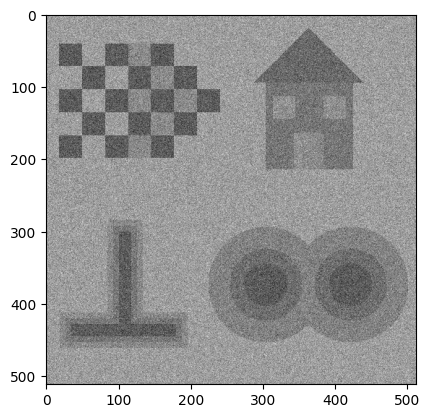

In [4]:
# i)

psnr = 10 
sigma = 0.316
mean=0

# Add the noise to the original image
noisy_img10 = np.random.normal(mean,sigma,img.shape)
noisy_img10 = noisy_img10.reshape(img.shape)
noisy_img10 = np.add(img, noisy_img10)

# Display the noisy image
plt.imshow(noisy_img10,cmap='gray')

1.2

Build a function named EdgeDetect following the steps below.

1.2.1
Build 2 filters

In [5]:
# 2D Gaussian

sigma=0.1
n= int(np.ceil(3*sigma)*2+1)
gauss1D = cv2.getGaussianKernel(n, sigma)
gauss2D = gauss1D @ gauss1D.T






In [6]:
#Laplacian of Gaussian

x = np.linspace(-n, n, 2*n+1)
y = np.linspace(-n, n, 2*n+1)

# Create 2D arrays for x and y coordinates using meshgrid
X, Y = np.meshgrid(x, y)

# Compute the LoG filter
LoG = -(X**2 + Y**2)/(2*sigma**2)
LoG = LoG / (2 * np.pi * sigma**4)
LoG = LoG * np.exp(-(X**2 + Y**2)/(2*sigma**2))

# Normalize the filter to have zero mean and unit variance
LoG = LoG - np.mean(LoG)
LoG = LoG / np.sqrt(np.sum(LoG**2))



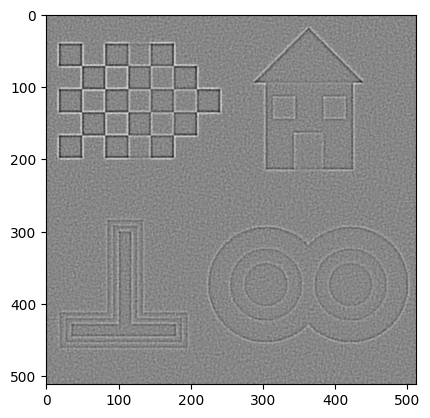

In [7]:
# L1 convolution LoG with img

filtered_img = cv2.filter2D(noisy_img20, -1, LoG)
plt.imshow(filtered_img, cmap='gray_r')

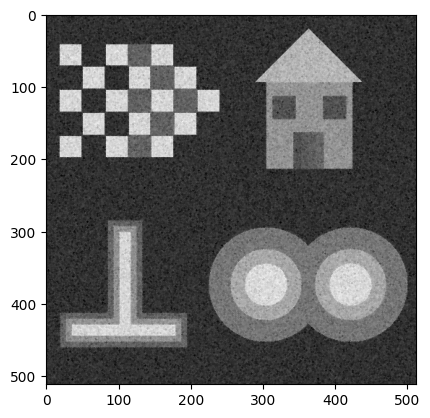

In [8]:
B = np.zeros((3,3), dtype=np.uint8)
B[1,:] = 1
B[:,1] = 1

Is= cv2.filter2D(noisy_img20,-1, gauss2D)

dilated= cv2.dilate(Is, B)
plt.imshow(dilated, cmap='gray_r')


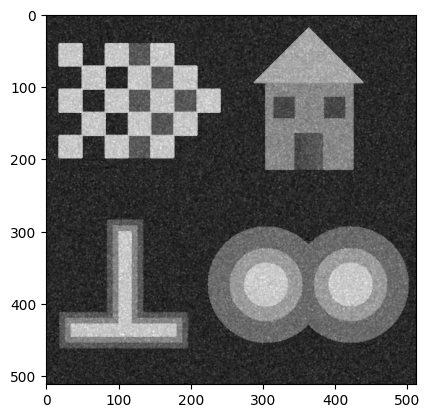

In [9]:
eroded=cv2.erode(Is,B)
plt.imshow(eroded, cmap='gray_r')

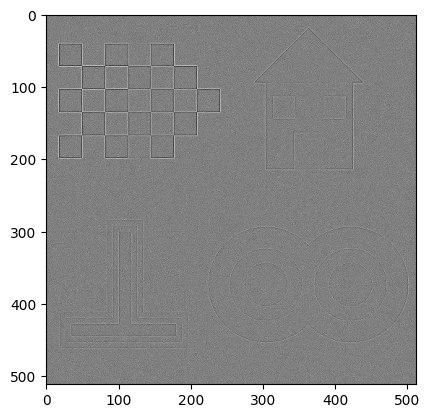

In [10]:
filtered_img2= dilated+eroded-2*Is
plt.imshow(filtered_img2, cmap = "gray_r")

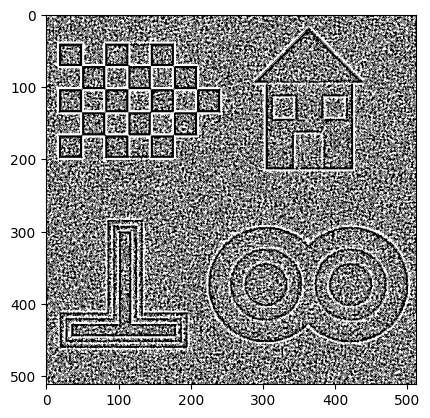

In [11]:
# Zero crossings

X= np.zeros(filtered_img.shape)
X[filtered_img>0]=1
X[filtered_img==0]=1

plt.imshow(X,cmap = "gray_r")


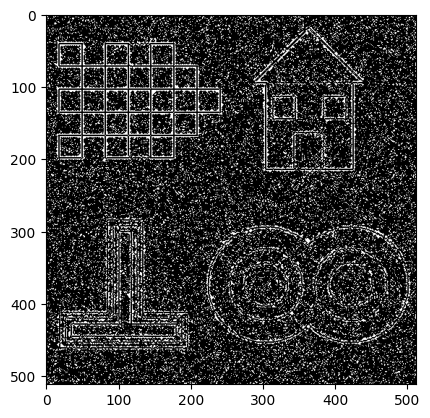

In [12]:
Y= cv2.dilate(X,B)-cv2.erode(X,B)
plt.imshow(Y,cmap = "gray_r")

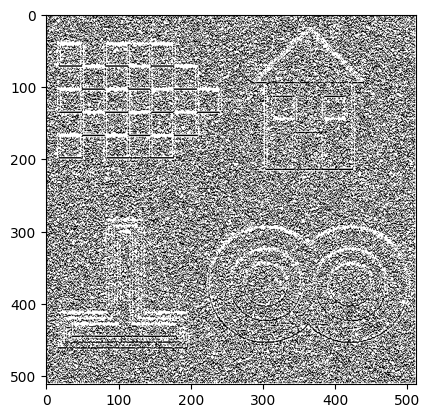

In [13]:
# Reject zero crossings in smooth areas.

theta=0.0

grad= np.gradient(Is)
max_grad= np.max(grad)

result=np.zeros(Y.shape)

for i in range(1, Y.shape[0]-1):
    for j in range(1,Y.shape[1]-1):
        if ((Y[i,j] > 0) and grad[0][i,j] > theta * max_grad):
            result[i,j] = 1 
plt.imshow(result,cmap = "gray_r") 

In [14]:
sigma=1
n= int(np.ceil(3*sigma)*2+1)
gaussian_kernel= cv2.getGaussianKernel(sigma, n)
#i)
twodgaussian=gaussian_kernel*gaussian_kernel.T

#ii)
x, y= np.meshgrid(np.arange(-n // 2 + 1, n // 2 + 1),
                   np.arange(-n // 2 + 1, n // 2 + 1))

gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))

LoG = ((x**2 + y**2 - 2 * sigma**2) / (sigma**4)) * gaussian
LoG= LoG-np.mean(LoG)




1.2.2

Approximate the normalized image with convolution of image with LoG or non linearly.

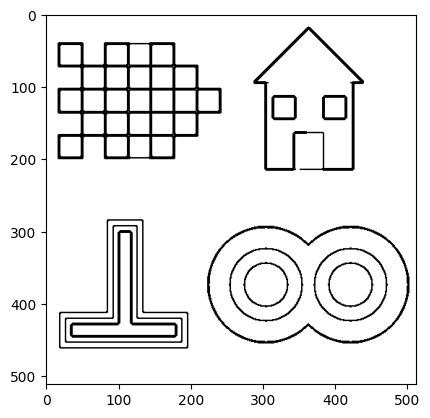

In [16]:
sigma=1.2
theta=0.2
type='linear'
B = np.zeros((3,3), dtype=np.uint8)
B[1,:] = 1
B[:,1] = 1
n= int (np.ceil (3*sigma)*2+1)
gauss1D = cv2.getGaussianKernel(n, sigma)
gauss2D = gauss1D @ gauss1D.T
x, y = np.meshgrid(np.arange(-n // 2 + 1, n // 2 + 1),
                    np.arange(-n // 2 + 1, n // 2 + 1))

gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
LoG = ((x**2 + y**2 - 2 * sigma**2) / (sigma**4)) * gaussian
LoG = LoG - np.mean(LoG)
filtered_img= cv2.filter2D(img, -1,gauss2D )

if (type == 'linear') :
    L= cv2.filter2D(img,-1,LoG)
elif (type == 'nonlinear'):
    dilation= cv2.dilate(filtered_img,B)
    erosion= cv2.erode(filtered_img,B)
    L=dilation+erosion-2*filtered_img

else:
    raise ValueError("Invalid value for 'type': must be 'linear' or 'nonlinear'.")


X = np.zeros_like(L, dtype=np.uint8)
X = np.where(L >= 0, 1, 0).astype(np.uint8)
dilationX= cv2.dilate(X,B)
erosionX= cv2.erode(X,B)
Y= dilationX-erosionX

grad_x, grad_y = np.gradient(filtered_img, axis=(0, 1))


grad_norm = np.sqrt(grad_x**2 + grad_y**2)

max_grad_norm = np.max(grad_norm)


edge_mask = (grad_norm > theta * max_grad_norm).astype(np.uint8)

plt.imshow(edge_mask, cmap='gray_r')

In [17]:
def EdgeDetect (img, sigma, theta, type):

    # Kernel

    B = np.zeros((3,3), dtype=np.uint8)
    B[1,:] = 1
    B[:,1] = 1

    n= int (np.ceil (3*sigma)*2+1)

    # 2D Gaussian

    gauss1D = cv2.getGaussianKernel(n, sigma)
    gauss2D = gauss1D @ gauss1D.T

    # Laplacian of Gaussian

    x = np.linspace(-n, n, 2*n+1)
    y = np.linspace(-n, n, 2*n+1)

    # Create 2D arrays for x and y coordinates using meshgrid
    X, Y = np.meshgrid(x, y)

    LoG = -(X**2 + Y**2)/(2*sigma**2)
    LoG = LoG / (2 * np.pi * sigma**4)
    LoG = LoG * np.exp(-(X**2 + Y**2)/(2*sigma**2))

    LoG = LoG - np.mean(LoG)
    LoG = LoG / np.sqrt(np.sum(LoG**2))

    # Smoothed Image
    Is= cv2.filter2D(img, -1,gauss2D )

    # Check type of filter
    if (type == 'linear') :
        L= cv2.filter2D(img,-1,LoG)
    elif (type == 'nonlinear'):
        L=cv2.dilate(Is,B)+cv2.erode(Is,B)-2*Is
    else:
        raise ValueError("Invalid value for 'type': must be 'linear' or 'nonlinear'.")

    # Create the binary image
    X = np.zeros_like(L, dtype=np.uint8)
    X = np.where(L >= 0, 1, 0).astype(np.uint8)
    
    Y= cv2.dilate(X,B)-cv2.erode(X,B)

    grad_x, grad_y = np.gradient(Is, axis=(0, 1))


    grad_norm = np.sqrt(grad_x**2 + grad_y**2)

    # Threshold the gradient magnitude to reject zero crossings in gentle areas
    grad_mag_thresholded = np.where(grad_norm >= theta * np.max(grad_norm), grad_norm, 0)

    # Combine the zero crossings and gradient magnitude to get the final edge map
    result = np.where(Y == 1, grad_mag_thresholded, 0)

    return( result)





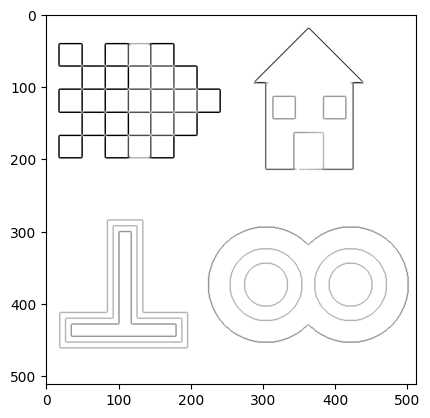

In [18]:
D = EdgeDetect(img, 1.5 ,0.2,'nonlinear')
plt.imshow(D, cmap='gray_r')

1.3

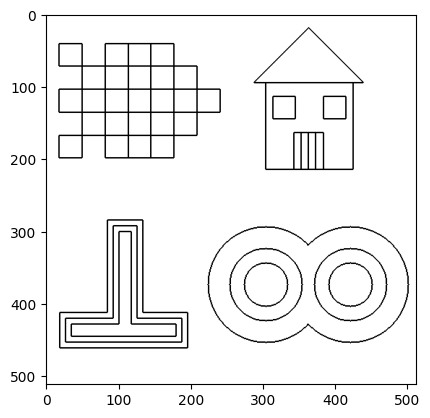

In [19]:
M = cv2.dilate(img, B) - cv2.erode( img, B)
T = (M > 0.01* np.max(M)).astype(np.uint8)

plt.imshow(T, cmap='gray_r')
plt.show()


In [20]:
def evaluation(D,T):

    # Calculate the intersection of D and T
    intersection = np.logical_and(D, T)

    # Calculate Precision and Recall
    precision = np.count_nonzero(intersection) / np.count_nonzero(D)
    recall = np.count_nonzero(intersection) / np.count_nonzero(T)

    # Calculate the quality criterion C
    C = (precision + recall) / 2

    return(C)


In [21]:
evaluation(D,T)

0.9772414049782467

1.4

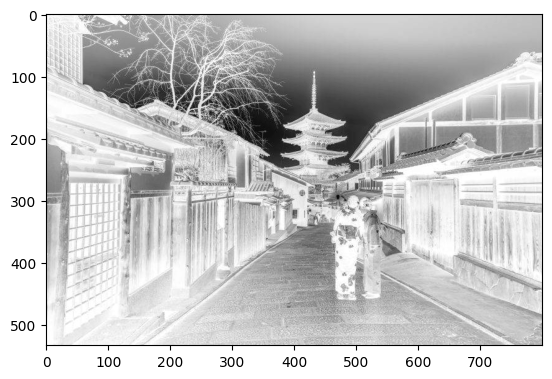

In [22]:
kyoto_img = cv2.imread('kyoto_edges.jpg', cv2.IMREAD_GRAYSCALE)
kyoto_img = kyoto_img.astype(np.float64)/255

plt.imshow(kyoto_img,cmap = "gray_r")


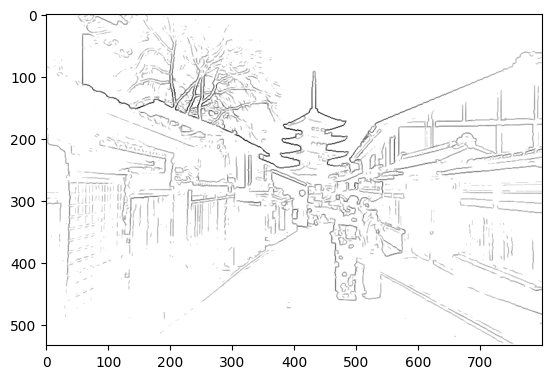

In [23]:
kyoto_edges= EdgeDetect(kyoto_img, 1.5, 0.2, 'nonlinear')

plt.imshow(kyoto_edges,cmap = "gray_r")



# 2ο ΜΕΡΟΣ


import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=1)
        ax.add_patch(circ)

    return ax

In [ ]:
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

2.1 

Ανίχνευση Γωνιών

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


sigma = 2
r = 2.5
k = 0.1
theta_corn = 0.05
s = 1.5
N = 4

gauss1D = cv2.getGaussianKernel(N, sigma)  # Column vector
gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel
gauss1Dr = cv2.getGaussianKernel(N, r)  # Column vector
gauss2Dr = gauss1Dr @ gauss1Dr.T  # Symmetric gaussian kernel

I = cv2.imread('kyoto_edges.jpg')
I=cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I= np.float32(I)

Is = cv2.filter2D(I, -1, gauss2D)

Ix, Iy = np.gradient(Is)

Ix2 = np.square(Ix)
Ixy = Ix * Iy
Iy2 = np.square(Iy)

j1 = cv2.filter2D(Ix2, -1, gauss2Dr)
j2 = cv2.filter2D(Ixy, -1, gauss2Dr)
j3 = cv2.filter2D(Iy2, -1, gauss2Dr)

lambda_plus = 1 / 2 * (j1 + j3 + np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))
lambda_minus = 1 / 2 * (j1 + j3 - np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))

R = lambda_plus * lambda_minus - k * (lambda_plus + lambda_minus) ** 2

ns = np.ceil(3 * sigma) * 2 + 1
B_sq = disk_strel(ns)
Cond1 =( R == cv2.dilate(R, B_sq))

maxR = np.max(R)
Cond2 = (R > theta_corn * maxR)

# create a binary mask with the same shape as the input image
corners = np.zeros_like(I)

# set the values of the pixels that are corners to 1
corners[Cond1 & Cond2] = 1

plt.imshow(I, cmap='gray')
plt.plot(np.nonzero(corners)[1], np.nonzero(corners)[0], 'r.')
plt.show()